In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

In [ ]:
from transformers.models.vit.modeling_vit import *

class ModViTForImageClassification(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__(config)

        self.num_labels = config.num_labels
        self.vit = ViTModel(config, add_pooling_layer=False, use_mask_token=True)

        # Classifier head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) if config.num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.vit(
            pixel_values,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


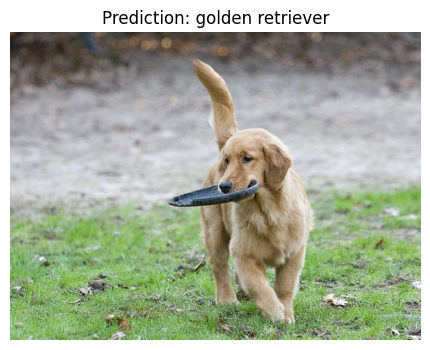

In [ ]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

In [ ]:
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

In [ ]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()
dataset = load_dataset("mrm8488/ImageNet1K-val")['train']

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
dataset.set_transform(preprocess)


batch_size = 256
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
# train_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 100%|██████████| 50000/50000 [00:24<00:00, 2023.63 examples/s]
Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(mask_gen_model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(1):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)
        sim = mask_gen_model.forward(model=pred_model, pixel_values=pixel_values)
        mask, masked_pred_logits = mask_gen_model.sample_one_step(model=pred_model, pixel_values=pixel_values, sim=sim)
        pred_logits = mask_gen_model.get_pred_logits(model=pred_model, pixel_values=pixel_values)
        loss_dict = mask_gen_model.loss_func(sim=sim, mask=mask, masked_pred_logits=masked_pred_logits, pred_logits=pred_logits)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss_dict['loss'].item():.4f}, " 
                             f"Reward Loss = {loss_dict['reward_loss'].item():.4f}, "
                             f"Mask Loss = {loss_dict['mask_loss'].item():.4f} "
                             f"mask_mean = {loss_dict['mask_mean'].item():.4f} "
                             f"prob_mean = {loss_dict['prob_mean'].item():.4f} "
                             )



  0%|          | 0/196 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 456.00 MiB. GPU 0 has a total capacity of 79.10 GiB of which 52.31 MiB is free. Process 220222 has 59.70 GiB memory in use. Including non-PyTorch memory, this process has 19.33 GiB memory in use. Of the allocated memory 18.46 GiB is allocated by PyTorch, and 226.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

device(type='cuda')